In [62]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "./checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab20")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

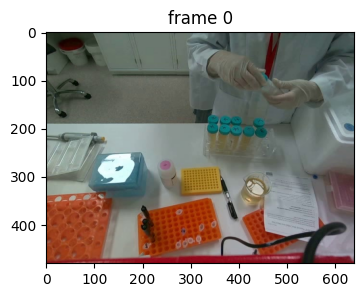

In [63]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/mnt/data/qizhezhang/allDataset/ProBio_valid/004/images"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
# frame_idx = 0
# plt.figure(figsize=(4, 3))
# plt.title(f"frame {frame_idx}")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [66]:
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

import json
with open(os.path.join(video_dir, '../label.json'), "rb") as f:
    label = json.load(f)
    
objects = {}
for frame in label:
    for item in frame['items']:
        if item['object_id'] not in objects:
            seg = item['segmentation']

            from pycocotools import mask
            import numpy as np
            rle = mask.frPyObjects(seg, 480, 640)
            binary_mask = mask.decode(rle)
            if len(binary_mask.shape) == 3:
                binary_mask = np.max(binary_mask, axis=2)
            objects[item['object_id']] = {'first_frame': int(frame['path']), 'mask': binary_mask}
    
# import math
# plt.figure(figsize=(4, 10))
# a = int(math.sqrt(len(objects)))+1
# fig,axes = plt.subplots(a,a,figsize=(4*a, 4*a))

# for i,item in enumerate(objects):
#     obj = objects[item]
#     ann_frame_idx = obj['first_frame']  # the frame index we interact with
#     ann_obj_id = item  # give a unique id to each object we interact with (it can be any integers)

#     labels = np.array([1], np.int32)
#     _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
#         inference_state=inference_state,
#         frame_idx=ann_frame_idx,
#         obj_id=ann_obj_id,
#         mask=obj['mask']
#     )

#     # show the results on the current (interacted) frame
#     axes[i//a][i%a].set_title(f"frame {ann_frame_idx} Object {ann_obj_id}")
#     axes[i//a][i%a].imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
#     # show_points(points, labels,axes[i//a][i%a])
#     show_mask((out_mask_logits[-1] > 0.0).cpu().numpy(), axes[i//a][i%a], obj_id=int(out_obj_ids[-1]))

for i,item in enumerate(objects):
    obj = objects[item]
    ann_frame_idx = obj['first_frame']  # the frame index we interact with
    ann_obj_id = int(item)  # give a unique id to each object we interact with (it can be any integers)

    labels = np.array([1], np.int32)
    _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        mask=obj['mask']
    )

frame loading (JPEG):   0%|          | 0/39 [00:00<?, ?it/s]

frame loading (JPEG): 100%|██████████| 39/39 [00:00<00:00, 39.22it/s]


In [69]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
# vis_frame_stride = 2
# plt.close("all")
# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

propagate in video: 100%|██████████| 39/39 [00:03<00:00, 11.12it/s]


In [ ]:
import os

results_path = './results'

def sam2_result_to_file(video_segments,file_name):
    # 确保结果目录存在
    os.makedirs(results_path, exist_ok=True)
    
    # 打开结果文件
    with open(os.path.join(results_path, f'{file_name}.txt'), 'w') as f:
        for frame,items in video_segments.items():
            for item,mask in items.items():
                # 计算掩码的边界框 (L, T, W, H)
                rows = np.any(mask, axis=1)
                cols = np.any(mask, axis=0)
                if rows.any():
                    top, bottom = np.where(rows)[0][[0, -1]]
                    left, right = np.where(cols)[0][[0, -1]]
                    width = right - left + 1
                    height = bottom - top + 1
                else:
                    top, left, width, height = 0, 0, 0, 0
                f.write(f'{frame}, {item}, {left}, {top}, {width}, {height}, 1, -1, -1, -1\n')

sam2_result_to_file(video_segments, file_name)